In [45]:
! pip install opencv-python
! pip install ftfy regex tqdm
! pip install streamlit
! pip install torchray
! pip install torchvision

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from model import build_model
from clip_ import load, tokenize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import streamlit as st
from torchray.attribution.grad_cam import grad_cam
from matplotlib import rc
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib

In [2]:
torch.cuda.is_available()

False

In [3]:
def show_cam_on_image(img, mask, neg_saliency=False):
    if neg_saliency:
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_RAINBOW)
    else:
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def show_overlapped_cam(img, neg_mask, pos_mask):
    neg_heatmap = cv2.applyColorMap(np.uint8(255 * neg_mask), cv2.COLORMAP_RAINBOW)
    pos_heatmap = cv2.applyColorMap(np.uint8(255 * pos_mask), cv2.COLORMAP_JET)
    neg_heatmap = np.float32(neg_heatmap) / 255
    pos_heatmap = np.float32(pos_heatmap) / 255
    # try different options: sum, average, ...
    heatmap = neg_heatmap + pos_heatmap
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [104]:
def interpret_vit(image, text, model, device, neg_saliency=False, index=None):
    
    image_relevance, image = vit_relevance(image, text, model, device, neg_saliency=neg_saliency, index=index)
    vis = show_cam_on_image(image, image_relevance, neg_saliency=neg_saliency)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    
    plt.imshow(vis)

def interpret_vit_overlapped(image, text, model, device, index=None):
    
    pos_image_relevance, _ = vit_relevance(image, text, model, device, neg_saliency=False, index=index)
    neg_image_relevance, image = vit_relevance(image, text, model, device, neg_saliency=True, index=index)

    vis = show_overlapped_cam(image, neg_image_relevance, pos_image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)

In [5]:
def rn_relevance(image, text, model, device, neg_saliency=False, index=None):   
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    if neg:
        objective = -text_features_new
    else:
        objective = text_features_new
        
    objective = (objective * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), objective, saliency_layer=layer)
        


    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    return image_relevance, image

In [6]:
def interpret_rn(image, text, model, device, neg_saliency=False, index=None):   
   
    image_relevance, image = rn_relevance(image, text, model, device, neg_saliency=neg_saliency, index=index)
    vis = show_cam_on_image(image, image_relevance, neg_saliency=neg_saliency)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    
def interpret_rn_overlapped(image, text, model, device, index=None):   
   
    pos_image_relevance, _ = rn_relevance(image, text, model, device, neg_saliency=False, index=index)
    neg_image_relevance, image = rn_relevance(image, text, model, device, neg_saliency=True, index=index)

    vis = show_overlapped_cam(image, neg_image_relevance, pos_image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)

In [7]:
st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_rn, preprocess = load("RN50", device=device, jit=False)
model, preprocess = load("ViT-B/32", device=device, jit=False)

2021-11-30 15:04:37.093 
  command:

    streamlit run /home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py [ARGUMENTS]
/home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [9]:
def sim_score(model, image, texts):
        texts = tokenize(texts).to(device)
        logits_per_image, logits_per_text = model(image, texts)
        probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

        return probs[0]

In [62]:
root = "../Images/"
img_ids = ["horse&dog.jpg", "horse&sheep.jpg", "cow&sheep.jpg"]#, "vase_or_face.png", "duck-rabbit.jpeg"]

text_lists = [["a horse", "a dog"],
              ["a horse", "a sheep"],
              ["a cow", "a sheep"],
              ]

model_types = ["ViT"]

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f4fa9601730>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


/home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [106]:
def vit_relevance(image, text, model, device, neg_saliency=False, index=None):

    model.visual.eval()
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    similarity = image_features_new[0].dot(text_features_new[0])
 
    
        
 
    
    #model.visual.zero_grad()
    #objective.backward(retain_graph=True)
 
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype,requires_grad=False).to(device)
    upsample = torch.nn.UpsamplingBilinear2d(
                size=image.shape[-2])
    
    scores = torch.zeros(len(image_attn_blocks))
    
    #n_image = (image - image.min()) / (image.max() - image.min())
    #n_image = image.unsqueeze(dim=1)

    cams = torch.zeros((12,12,50,50))
    for ind, blk in enumerate(image_attn_blocks):
        cam = blk.attn_probs
        cams[ind] = cam

    for ind, blk in enumerate(image_attn_blocks):
        cam = cams[ind].mean(dim=0)
        cam = cam.reshape(1, -1, cam.shape[-1], cam.shape[-1])
        cam = upsample(cam)
       
        cam = (cam-cam.min()) / (cam.max()-cam.min())     
        t = 0.09
        cam[cam>=t] = 1
        cam[cam<t] = 0

        masked_img = (image*cam)
        plt.imshow(masked_img.detach()[0].permute(1, 2, 0))
        masked_features = model.encode_image(masked_img)
        masked_features_norm = masked_features.norm(dim=-1, keepdim=True)
        masked_features_new = masked_features / masked_features_norm
        masked_sim = text_features_new[0].dot(masked_features_new[0])
        score =  masked_sim-similarity 
        if neg_saliency:
            score *=-1
       
        scores[ind]=score
    
    #scores = scores.clamp(min=0)
    print(scores)
    #scores = torch.nn.Softmax(dim=-1)(scores)
    #print(scores)
    # for ind,blk in enumerate(image_attn_blocks):
    cam = cams[-1]
    weight = scores[-1]
    cam = cam * weight
    #cam = cam.clamp(min=0)
    cam = cam.mean(dim=0) 
    R += torch.matmul(cam, R)
        
    R[0, 0] = 0
    image_relevance = R[0, 1:]
    
    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cpu().detach().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    return image_relevance, image


a horse


2021-11-30 20:09:46.880 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.017 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.143 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.264 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.432 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.678 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.803 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:47.952 Clipping input data to the valid range

tensor([-0.0362, -0.0281, -0.0328, -0.0414, -0.0308, -0.0379, -0.0325, -0.0344,
        -0.0294, -0.0381, -0.0281, -0.0285], grad_fn=<CopySlices>)


2021-11-30 20:09:48.870 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:48.985 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.098 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.207 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.321 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.447 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.625 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:49.763 Clipping input data to the valid range

tensor([0.0362, 0.0281, 0.0328, 0.0414, 0.0308, 0.0379, 0.0325, 0.0344, 0.0294,
        0.0381, 0.0281, 0.0285], grad_fn=<CopySlices>)
a dog


2021-11-30 20:09:50.512 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:50.623 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:50.727 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:50.835 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:50.945 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:51.044 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:51.204 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:51.341 Clipping input data to the valid range

tensor([-0.0169, -0.0131, -0.0171, -0.0202, -0.0157, -0.0168, -0.0157, -0.0118,
        -0.0133, -0.0183, -0.0053, -0.0093], grad_fn=<CopySlices>)


2021-11-30 20:09:52.325 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:52.430 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:52.538 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:52.630 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:52.783 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:52.885 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:53.005 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:53.102 Clipping input data to the valid range

tensor([0.0169, 0.0131, 0.0171, 0.0202, 0.0157, 0.0168, 0.0157, 0.0118, 0.0133,
        0.0183, 0.0053, 0.0093], grad_fn=<CopySlices>)
a horse


2021-11-30 20:09:54.028 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.124 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.235 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.343 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.442 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.559 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.668 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:54.782 Clipping input data to the valid range

tensor([-0.0083, -0.0154, -0.0145, -0.0153, -0.0158, -0.0153, -0.0075, -0.0196,
        -0.0129, -0.0223, -0.0119, -0.0273], grad_fn=<CopySlices>)


2021-11-30 20:09:55.674 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:55.788 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:55.884 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:56.006 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:56.097 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:56.219 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:56.332 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:56.444 Clipping input data to the valid range

tensor([0.0083, 0.0154, 0.0145, 0.0153, 0.0158, 0.0153, 0.0075, 0.0196, 0.0129,
        0.0223, 0.0119, 0.0273], grad_fn=<CopySlices>)
a sheep


2021-11-30 20:09:57.484 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:57.582 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:57.688 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:57.788 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:57.907 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:58.006 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:58.116 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:58.224 Clipping input data to the valid range

tensor([-0.0050, -0.0206, -0.0129, -0.0172, -0.0210, -0.0145, -0.0006, -0.0215,
        -0.0172, -0.0196, -0.0162, -0.0288], grad_fn=<CopySlices>)


2021-11-30 20:09:58.991 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.161 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.362 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.519 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.653 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.781 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:09:59.914 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:00.052 Clipping input data to the valid range

tensor([0.0050, 0.0206, 0.0129, 0.0172, 0.0210, 0.0145, 0.0006, 0.0215, 0.0172,
        0.0196, 0.0162, 0.0288], grad_fn=<CopySlices>)
a cow


2021-11-30 20:10:00.991 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.127 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.262 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.396 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.523 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.652 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.793 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:01.912 Clipping input data to the valid range

tensor([-0.0206, -0.0173, -0.0048, -0.0010, -0.0022,  0.0194,  0.0196,  0.0087,
         0.0231, -0.0042,  0.0078, -0.0153], grad_fn=<CopySlices>)


2021-11-30 20:10:02.747 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:02.880 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.048 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.237 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.358 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.455 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.567 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:03.674 Clipping input data to the valid range

tensor([ 0.0206,  0.0173,  0.0048,  0.0010,  0.0022, -0.0194, -0.0196, -0.0087,
        -0.0231,  0.0042, -0.0078,  0.0153], grad_fn=<CopySlices>)
a sheep


2021-11-30 20:10:04.448 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:04.569 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:04.678 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:04.777 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:04.888 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:04.983 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:05.104 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:05.202 Clipping input data to the valid range

tensor([-0.0234, -0.0167,  0.0012,  0.0050,  0.0031,  0.0200,  0.0266,  0.0085,
         0.0278,  0.0057,  0.0142, -0.0070], grad_fn=<CopySlices>)


2021-11-30 20:10:05.841 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:05.949 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.050 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.160 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.263 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.398 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.537 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-11-30 20:10:06.675 Clipping input data to the valid range

tensor([ 0.0234,  0.0167, -0.0012, -0.0050, -0.0031, -0.0200, -0.0266, -0.0085,
        -0.0278, -0.0057, -0.0142,  0.0070], grad_fn=<CopySlices>)


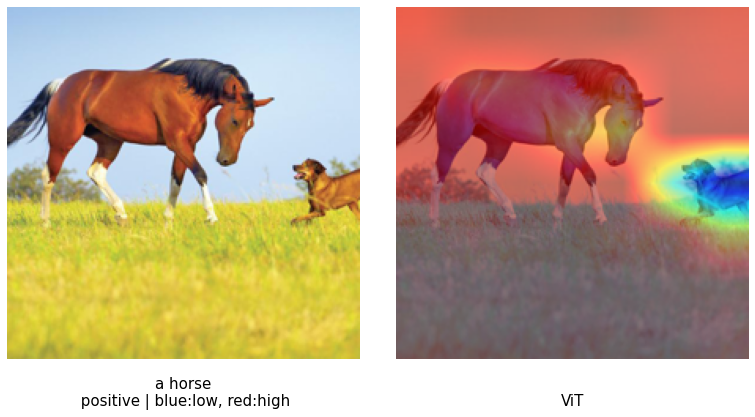

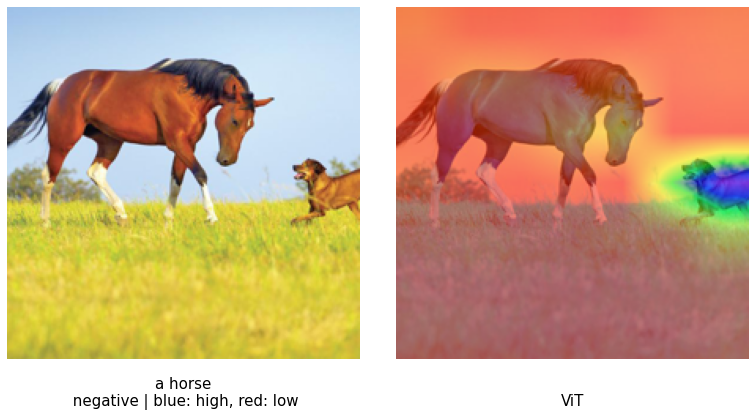

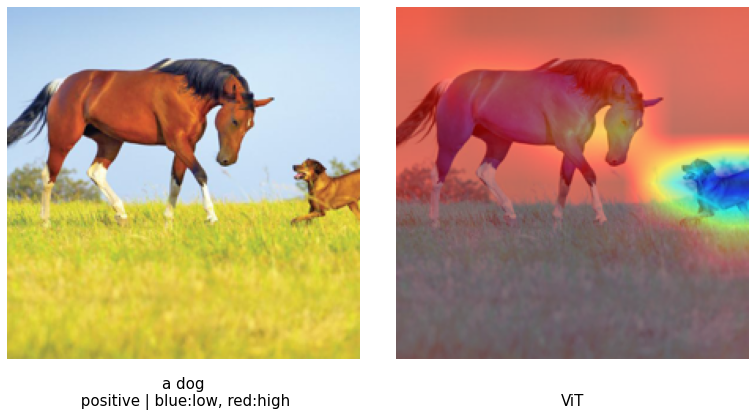

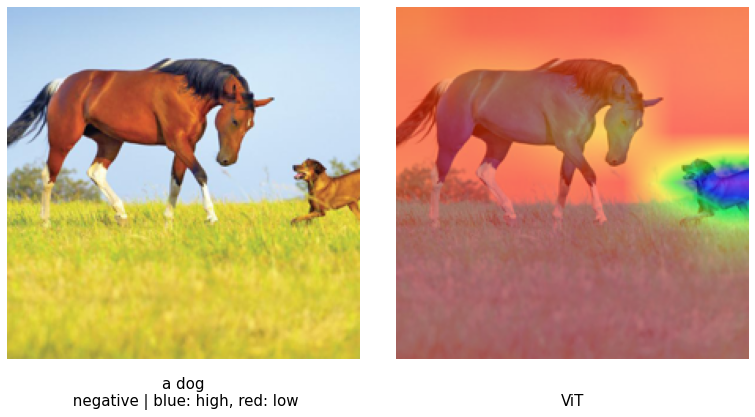

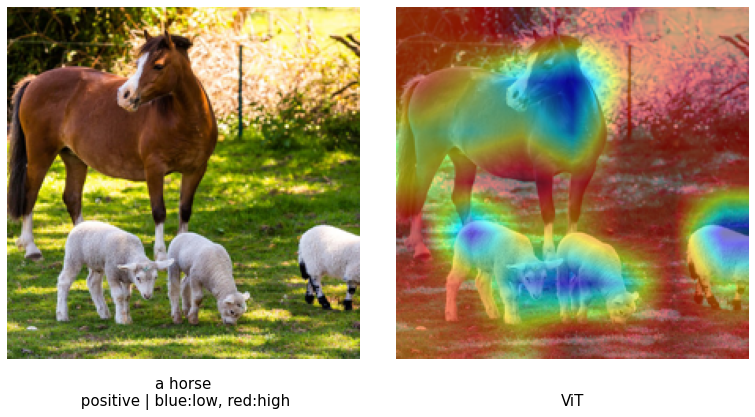

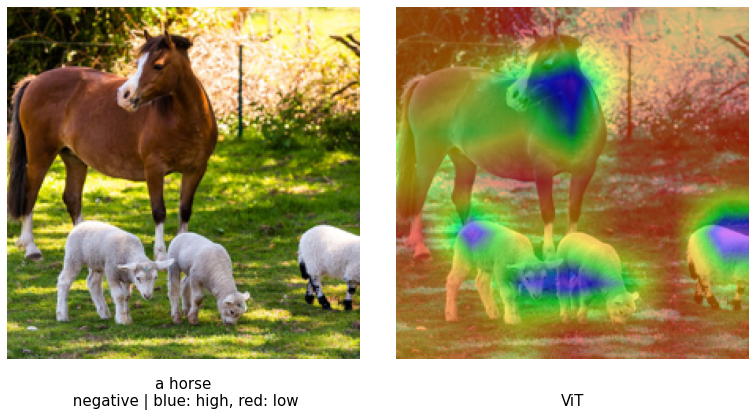

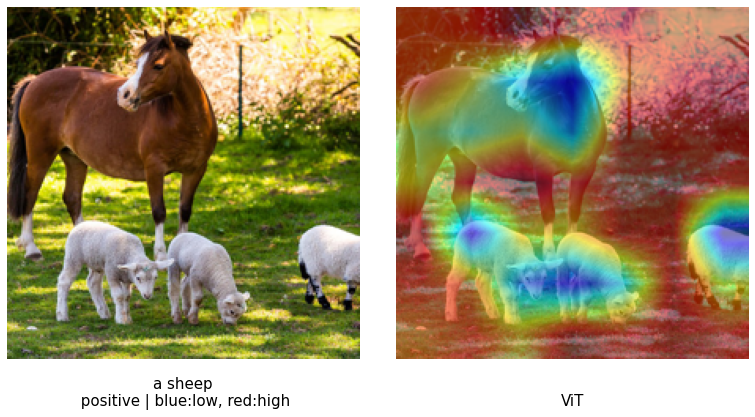

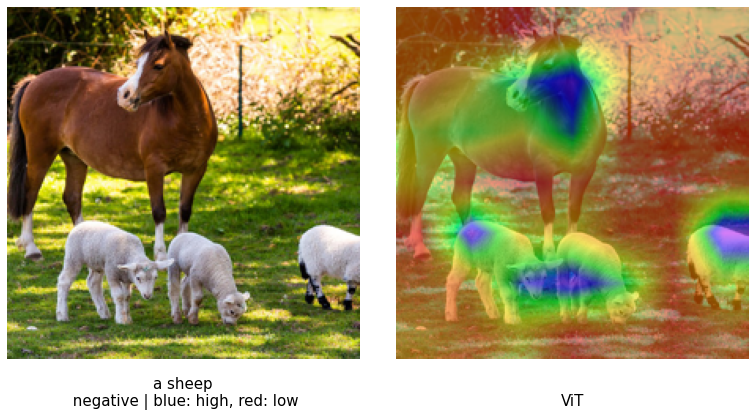

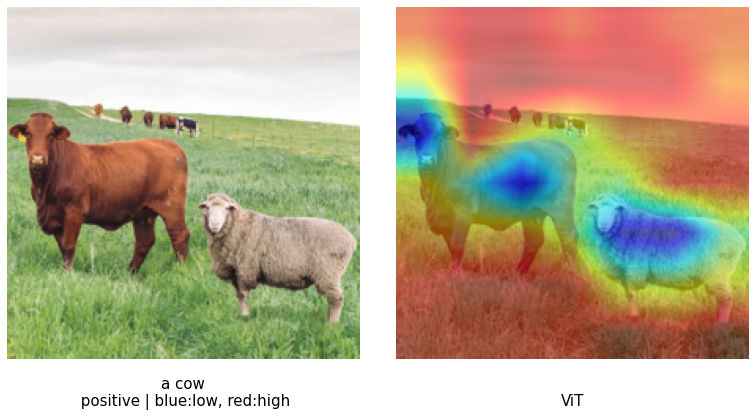

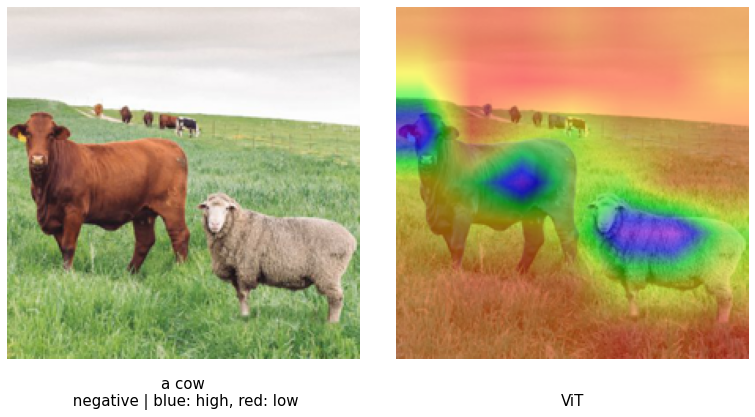

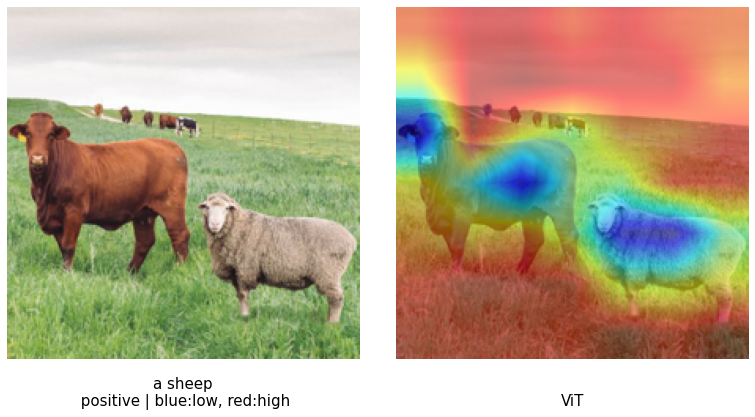

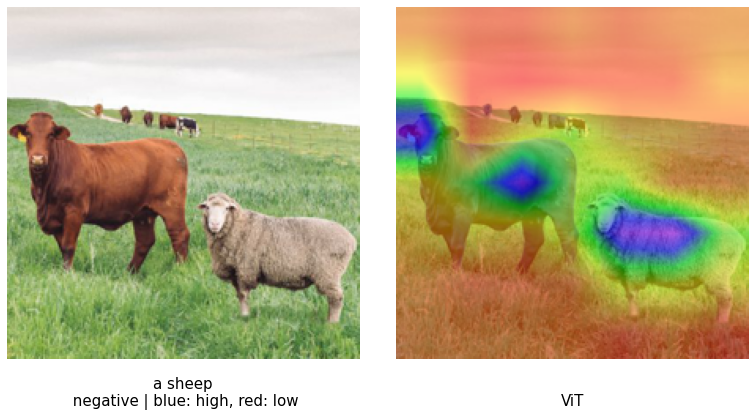

In [107]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))

for id_, img_id in enumerate(img_ids):
    texts = text_lists[id_]
    for t_id, text in enumerate(texts):
        print(text)
        t_text = tokenize(text).to(device)
        
        for neg in [False, True]:#, None]:
            
            img_path =  os.path.join(root, img_id )
            image = ori_preprocess(Image.open(img_path))


            plt.figure(figsize=(16, 16))
            plt.tight_layout()
            plt.subplot(131)
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            if neg==None: caption = text+"\n overlapped  | blue:neg, red: pos"
            elif neg==True: caption = text+"\n negative | blue: high, red: low"
            else: caption = text+ "\n positive | blue:low, red:high"
            plt.title(caption, **font, y=-0.15)
        
            p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

            subplot = 132
                
            for model_id, model_type in enumerate(model_types):
           
                plt.subplot(subplot+model_id)
            
                if model_type=="ViT":
                    
                    if not neg==None:
                        interpret_vit(model=model, image=p_image, text=t_text, neg_saliency=neg, device=device, index=0)
                    else:
                        interpret_vit_overlapped(model=model, image=p_image, text=t_text, device=device, index=0)

                else:
                        
                    if not neg==None:
                        interpret_rn(model=model_rn, image=p_image, text=t_text, neg_saliency=neg, device=device, index=0)
                    else:
                        interpret_rn_overlapped(model=model_rn, image=p_image, text=t_text, device=device, index=0)
                            
                

                plt.title(model_type, **font,y=-0.15)
                plt.tight_layout()
                plt.axis('off')

                # dir_path = f'comparison/img_text/'
                # if not os.path.exists(dir_path):
                #     os.mkdir(dir_path)
                # plt.savefig(f'{dir_path}{model_type}_{img_id}_vs_{t_id}.jpg', bbox_inches='tight')